In [24]:
import numpy as np
import scipy
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.sparse import diags
import time
import skimage.measure


In [2]:
# Preprocessing of images: background should be dark. Downsampling if necessary.
Image1=plt.imread('sub-MD787_sample-1-0454_ce-nissl_BF.png')
Image1 = np.mean(Image1[...,:3],-1)
ind = Image1>0.95
ind = np.prod(ind,1)==0
Image1 = Image1[ind]
Image1=np.quantile(Image1,0.99)-Image1
Image1 = skimage.measure.block_reduce(Image1, (3,3), np.mean)
Image1.shape

(206, 280)

In [4]:
# Preprocessing of images: background should be dark. Downsampling if necessary.
Image0=plt.imread('sub-MD787_sample-1-0457_ce-nissl_BF.png')
Image0 = np.mean(Image0[...,:3],-1)
ind = Image0>0.95
ind = np.prod(ind,1)==0
Image0 = Image0[ind]
Image0=np.quantile(Image0,0.99)-Image0
Image0 = skimage.measure.block_reduce(Image0, (3,3), np.mean)
Image0.shape

(216, 260)

In [5]:
# Create a list of images
ImageList=[Image0,Image1]

<IPython.core.display.Javascript object>


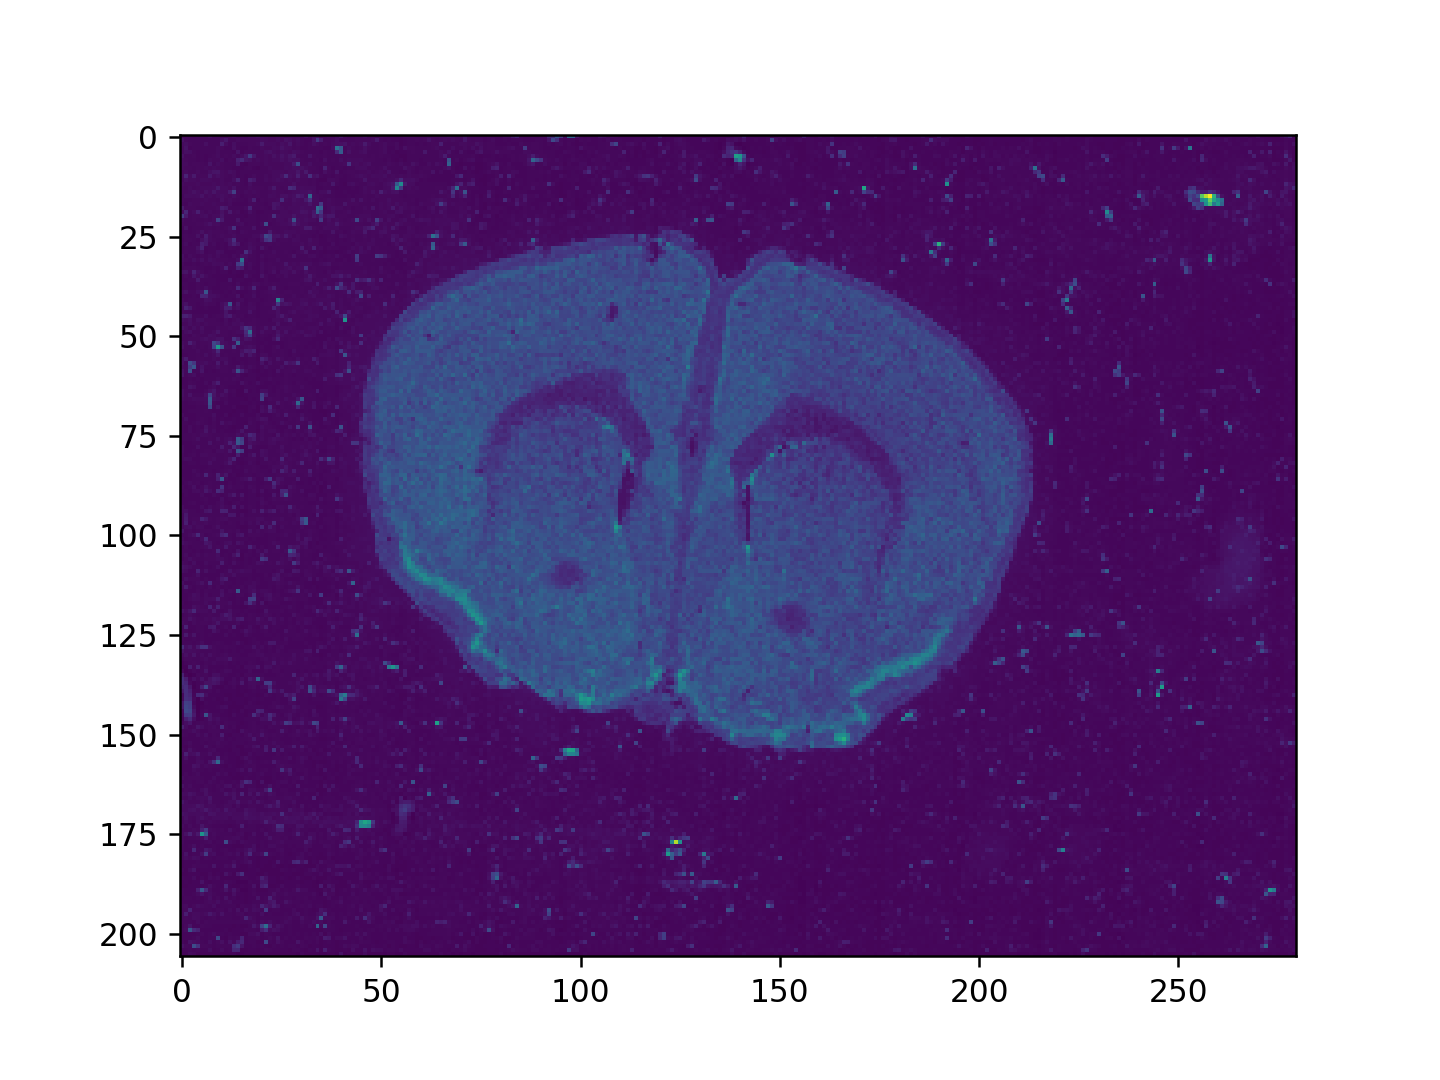

In [6]:
fig,ax = plt.subplots()
ax.imshow(Image1)

<IPython.core.display.Javascript object>


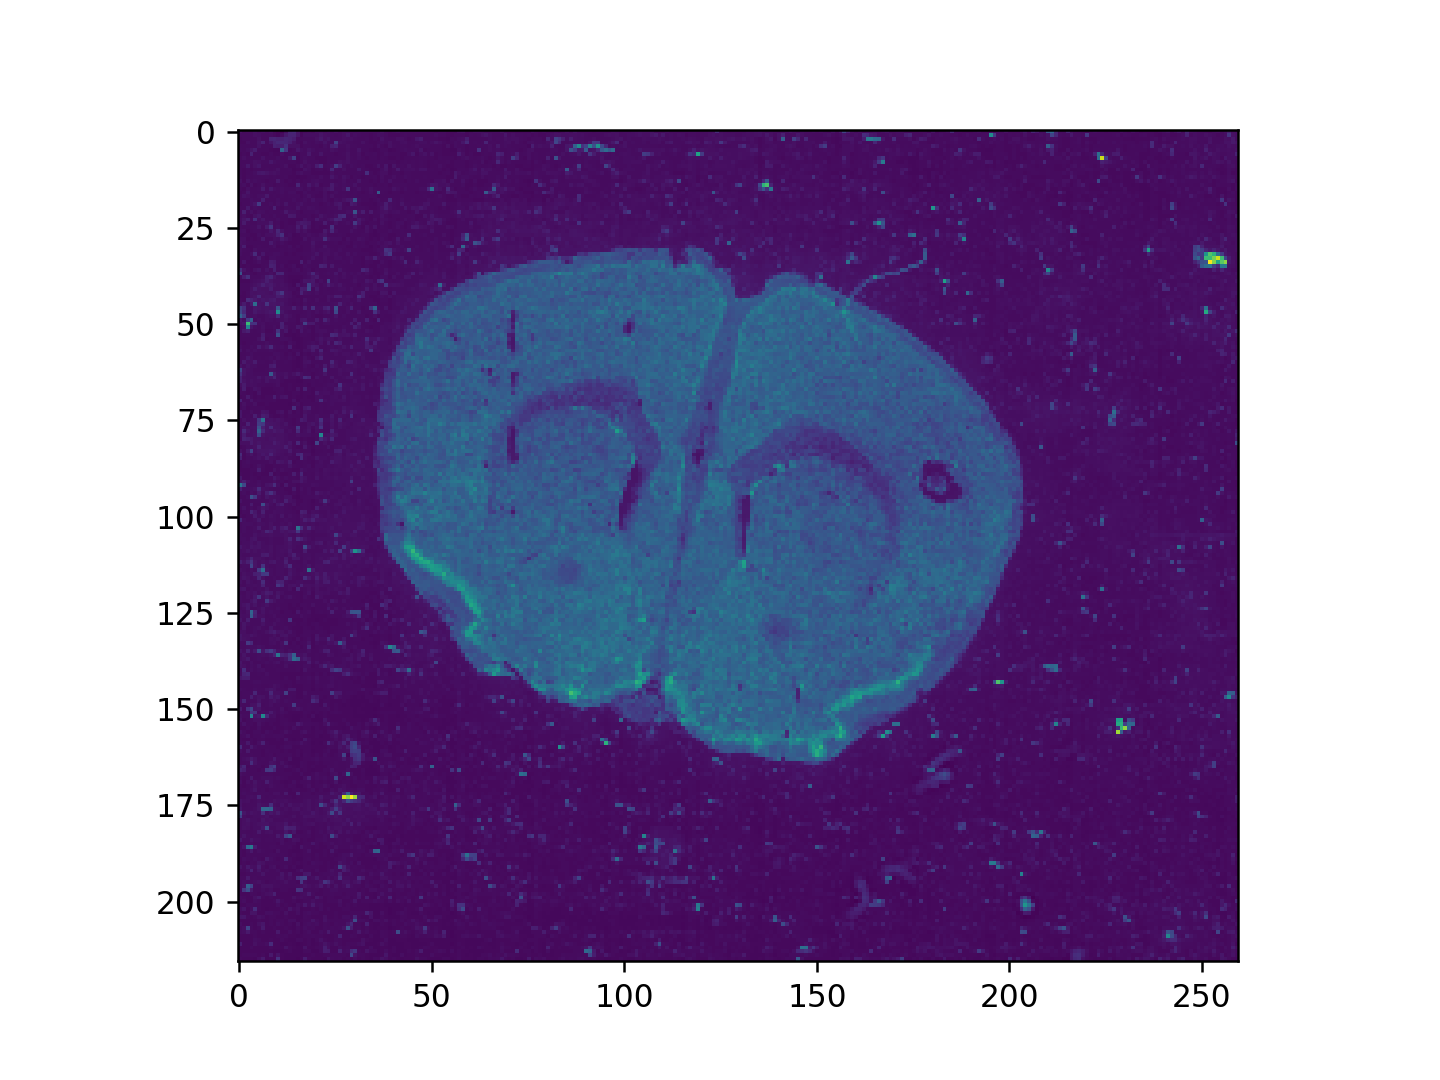

In [7]:
fig,ax = plt.subplots()
ax.imshow(Image0)

In [8]:
def SVD(thetan,cn,I,J,n,sigma):
    # set the standard deviation of Gaussian interpolation as sigma and write the rotation matrix at iteration n as Rn
    Rn=np.array([[np.cos(thetan),-np.sin(thetan)],[np.sin(thetan),np.cos(thetan)]])
    
    
    # set XIMatrix to be the (i,j)-coordinates of each pixel of image I
    locationI=np.meshgrid(np.linspace(0,I.shape[1]-1,I.shape[1]),np.linspace(0,I.shape[0]-1,I.shape[0]))
    XIMatrix=np.stack((locationI[1],locationI[0]),axis=-1)
    
    # Calculate the x-axis coordinates of the nearest point to the left of each transformed pixel of image I
    valX=(np.dot(XIMatrix,np.array([-dI[0]*Rn[1][0],dI[1]*Rn[0][0]]))+(Rn@XI[0][0])[0]+cn[0]-XJ[0][0][0])/dJ[1]
    
    # Keep only the non-negative x-axis coordinates
    

    
    
    valXmod=(valX>=(n+1))*valX
    
    # Keep only the non-nagative x-axis coordinates that are to the left of the rightmost x-axis coordinate of image J
    valXfinal=valXmod*(valXmod<=(nJ[1]-(n+1)))
    zeroX=(valX>=(n+1))*(valXmod<=(nJ[1]-(n+1)))
    
    # The x-axis distances between the transformed image I pixels and the nearest image J pixels
    diffx1=np.modf(valXfinal)[0]*dJ[1]
    
    # Calculate the y-axis coordinates of the nearest point under each transformed pixel of image I
    valY=(np.dot(XIMatrix,np.array([dI[0]*Rn[0][0],dI[1]*Rn[1][0]]))+(Rn@XI[0][0])[1]+cn[1]-XJ[0][0][1])/dJ[0]
    valYmod=(valY>=(n+1))*valY
  
    
    # Restrict to only those coordinates within the range of image J.
    valYfinal=valYmod*(valYmod<=(nJ[0]-(n+1)))
    zeroY=(valY>=(n+1))*(valYmod<=(nJ[0]-(n+1)))
    
    # The x-axis and y-axis distances between the transformed image I pixels and the nearest image J pixels
    diffy1=np.modf(valYfinal)[0]*dJ[0]

    
    
    # Obtain the (i,j)-coordinates of the 16 neartest image J pixels for each of the transformed image I pixels
    locxJ=np.modf(valXfinal)[1]
    locyJ=np.modf(valYfinal)[1]
    Original=(np.stack((locyJ,locxJ),axis=-1)).astype(int)
    
    # Prepare the truncation 
    Jpoints = np.zeros([2*n,2*n,XI.shape[1],XI.shape[0],2],dtype=int)
    Diffs=np.zeros([2*n,2*n,2,XI.shape[1],XI.shape[0]])
    
    expon=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jlist=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jposition_1=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jposition_2=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jposition=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0],2])
    W=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Cost=0
    WPsum=np.zeros([2*n,2*n,2])
    WQsum=np.zeros([2*n,2*n,2])
    WPsumm=np.array([0,0])
    WQsumm=np.array([0,0])
    
    # Begin SVD step
    for i in range(0,2*n):
        for j in range(0,2*n):
            Jpoints[i][j]=(Original-np.array([n-1,n-1])+np.array([i,j]))
            Diffs[i][j][0]=diffx1+(n-1-j)*dJ[1]
            Diffs[i][j][1]=diffy1+(n-1-i)*dJ[0]
            
            expon[i][j]=np.exp(-1*np.sum(np.square(Diffs[i][j]),axis=0)/(4*sigma**2))
            Jlist[i][j]=J[Jpoints[i][j][:,:,0].astype(int),Jpoints[i][j][:,:,1].astype(int)]   
            Jposition_1[i][j]=XJ[:,:,0].T[Jpoints[i][j][:,:,0].astype(int),Jpoints[i][j][:,:,1].astype(int)]
            Jposition_2[i][j]=XJ[:,:,1].T[Jpoints[i][j][:,:,0].astype(int),Jpoints[i][j][:,:,1].astype(int)]
            Jposition[i][j]=np.stack((Jposition_1[i][j],Jposition_2[i][j]),axis=-1)
            W[i][j]=zeroX*zeroY*I*Jlist[i][j]*expon[i][j]
            Cost=Cost+np.sum(W[i][j])
            WPsum[i][j]=np.sum(np.sum(np.stack((W[i][j].T*XI[:,:,0],W[i][j].T*XI[:,:,1]),axis=-1),axis=0),axis=0)
            WPsumm=WPsumm+WPsum[i][j]
            WQsum[i][j]=np.sum(np.sum(np.stack((W[i][j]*Jposition_1[i,j],W[i][j]*Jposition_2[i,j]),axis=-1),axis=0),axis=0)
            WQsumm=WQsumm+WQsum[i][j]
            
    Pmean=WPsumm/Cost
    Qmean=WQsumm/Cost
    XInew=np.transpose(XI-Pmean,(1,0,2))
    XIreshape=np.reshape(XInew,(XInew.shape[0]*XInew.shape[1],2))
    XJnew=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0],2])
    XJreshape=np.zeros([2*n,2*n,XI.shape[1]*XI.shape[0],2])
    Wdiag=[[None]*(2*n)]*(2*n)
    WYT=np.zeros([I.shape[0]*I.shape[1],2])
    for i in range(0,2*n):
        for j in range(0,2*n):
            XJnew[i][j]=Jposition[i][j]-Qmean
            XJreshape[i][j]=np.reshape(XJnew[i][j],(XJnew[i][j].shape[0]*XJnew[i][j].shape[1],2))
            Wdiag[i][j]=scipy.sparse.diags(W[i][j].flatten())
            WYT=WYT+Wdiag[i][j]@XJreshape[i][j]
            

    U,S,Vt = np.linalg.svd(XIreshape.T@WYT)
    
    # Extract the orthogonal matrix from the SVD decomposition
    OrthoMatrix = (U@Vt).T
   
    # Returns the rotation matrix, the translation vector, the angle of rotation, the truncated objective function and the smallest singular value
    return [OrthoMatrix,Qmean-OrthoMatrix@Pmean,np.arctan2(OrthoMatrix[1][0],OrthoMatrix[0][0]),Cost, np.min(S)]

In [9]:
def Grad(thetan,cn,I,J,n,sigma):
    # n is the number of layers of neighborhood points
    # set the standard deviation of Gaussian interpolation as sigma and write the rotation matrix at iteration n as Rn
    Rn=np.array([[np.cos(thetan),-np.sin(thetan)],[np.sin(thetan),np.cos(thetan)]])
    dRn=np.array([[-np.sin(thetan),-np.cos(thetan)],[np.cos(thetan),-np.sin(thetan)]])
    
    
    # set XIMatrix to be the (i,j)-coordinates of each pixel of image I
    locationI=np.meshgrid(np.linspace(0,I.shape[1]-1,I.shape[1]),np.linspace(0,I.shape[0]-1,I.shape[0]))
    XIMatrix=np.stack((locationI[1],locationI[0]),axis=-1)

    # Calculate the x-axis coordinates of the nearest point to the left of each transformed pixel of image I
    valX=(np.dot(XIMatrix,np.array([-dI[0]*Rn[1][0],dI[1]*Rn[0][0]]))+(Rn@XI[0][0])[0]+cn[0]-XJ[0][0][0])/dJ[1]

    val_=(dRn[0][0]*XI+dRn[1][0]*np.array([-1,1])*np.flip(XI,axis=-1)).T

    # Keep only the non-negative x-axis coordinates
    valXmod=(valX>=(n+1))*valX
    
    # Keep only the non-nagative x-axis coordinates that are to the left of the rightmost x-axis coordinate of image J
    valXfinal=valXmod*(valXmod<=(nJ[1]-(n+1)))
    zeroX=(valX>=(n+1))*(valXmod<=(nJ[1]-(n+1)))
    
    # The x-axis distances between the transformed image I pixels and the nearest image J pixels
    diffx1=np.modf(valXfinal)[0]*dJ[1]
    #print('diffx1 is',diffx1[0][0])
    #print('dJ1 is',dJ[1])
    #print('test 1 is', test1)
    
    
    # Calculate the y-axis coordinates of the nearest point under each transformed pixel of image I
    valY=(np.dot(XIMatrix,np.array([dI[0]*Rn[0][0],dI[1]*Rn[1][0]]))+(Rn@XI[0][0])[1]+cn[1]-XJ[0][0][1])/dJ[0]
    valYmod=(valY>=(n+1))*valY
    
    # Restrict to only those coordinates within the range of image J.
    valYfinal=valYmod*(valYmod<=(nJ[0]-(n+1)))
    zeroY=(valY>=(n+1))*(valYmod<=(nJ[0]-(n+1)))
   
    # The x-axis and y-axis distances between the transformed image I pixels and the nearest image J pixels
    diffy1=np.modf(valYfinal)[0]*dJ[0]

    # Obtain the (i,j)-coordinates of the 16 neartest image J pixels for each of the transformed image I pixels
    locxJ=np.modf(valXfinal)[1]
    locyJ=np.modf(valYfinal)[1]
    
    Original=(np.stack((locyJ,locxJ),axis=-1)).astype(int)
    Jpoints = np.zeros([2*n,2*n,XI.shape[1],XI.shape[0],2])
    Diffs=np.zeros([2*n,2*n,2,XI.shape[1],XI.shape[0]])
    dotp=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    expon=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jlist=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jposition_1=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jposition_2=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Jposition=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0],2])
    W=np.zeros([2*n,2*n,XI.shape[1],XI.shape[0]])
    Wa=np.zeros([2*n,2*n])
    Wb=np.zeros([2*n,2*n])
    Wc=np.zeros([2*n,2*n])
    Cost=0
    vect1=0
    vect2=0
    vect3=0
    for i in range(0,2*n):
        for j in range(0,2*n):
            Jpoints[i][j]=(Original-np.array([n-1,n-1])+np.array([i,j])).astype(int)
            Diffs[i][j][0]=diffx1+(n-1-j)*dJ[1]
            Diffs[i][j][1]=diffy1+(n-1-i)*dJ[0]
            dotp[i][j]=Diffs[i][j][0]*val_[0,:,:]+Diffs[i][j][1]*val_[1,:,:]
            expon[i][j]=np.exp(-1*np.sum(np.square(Diffs[i][j]),axis=0)/(4*sigma**2))
            Jlist[i][j]=J[Jpoints[i][j][:,:,0].astype(int),Jpoints[i][j][:,:,1].astype(int)]   

            W[i][j]=zeroX*zeroY*I*Jlist[i][j]*expon[i][j]
            Cost=Cost+np.sum(W[i][j])
            Wa[i][j]=np.sum(W[i][j]*dotp[i][j])
            vect1=vect1+Wa[i][j]
            Wb[i][j]=np.sum(W[i][j]*Diffs[i][j][0])
            vect2=vect2+Wb[i][j]
            Wc[i][j]=np.sum(W[i][j]*Diffs[i][j][1])
            vect3=vect3+Wc[i][j]
    return [np.array([vect1,vect2,vect3]),Cost]

In [10]:
# Nesterov-accelerated MM for a pair of images
def NestMM(theta,c,iteration,I,J,n,sigma):
    Cost=[]
    start=time.time()
    Time=[]
    thetaclist=[]
    thetaxlist=[theta,theta]
    cxlist=[c,c]
    for it in range(0,iteration):
        SVD1=SVD(theta,c,I,J,n,sigma)
        thetaxx=SVD1[2]
        cxx=SVD1[1]
        thetaxlist[0]=thetaxlist[1]
        thetaxlist[1]=thetaxx
        cxlist[0]=cxlist[1]
        cxlist[1]=cxx
        theta=thetaxlist[1]+(it/(it+3))*(thetaxlist[1]-thetaxlist[0])
        c=cxlist[1]+(it/(it+3))*(cxlist[1]-cxlist[0])
        
        thetaclist.append(np.array([theta,c[0],c[1]]))
        print('theta is',SVD1[2]*180/np.pi)
        print('translation is',SVD1[1])
        print('cost is',SVD1[3])
        Cost.append(SVD1[3])
        Time.append(time.time()-start)
        
    return [np.array([theta,c[0],c[1]]),Cost,Time,thetaclist]

In [13]:
# Nesterov MM for a sequence of images
CostList=[]
TimeList=[]

for i in range(0,1):
    
    dI = np.array([1,1])
    dJ = np.array([1,1])
    nI = np.array([ImageList[i].shape[0],ImageList[i].shape[1]])
    nJ = np.array([ImageList[i+1].shape[0],ImageList[i+1].shape[1]])
    def x_from_n_d(n,d,centered=True):
        return [np.arange(n_)*d_ - (n_-1)*d_/2.0*centered for n_,d_ in zip(n,d)]
    x0 = x_from_n_d(nI,dI)
    X0 = np.stack(np.meshgrid(*x0,indexing='ij'))
    x1 = x_from_n_d(nJ,dJ)
    X1 = np.stack(np.meshgrid(*x1,indexing='ij'))
    xI = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nI,dI)] # sometimes I will put the origin in the middle
    # check that origin is in the middle like this: np.mean(xI[0])
    # the pixel size is important because we want the translation vector to have physical units in microns
    xI[0],xI[1]=xI[1],xI[0]
    xJ = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nJ,dJ)]
    # now we'll build arrays that store pixel locations instead of lists
    xJ[0],xJ[1]=xJ[1],xJ[0]


    XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)
    XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)

    Result=NestMM(0.1,np.array([0,0]),50,ImageList[i],ImageList[i+1],4,1.0)
    # Gives the list of objective function values and list of time for each iteration
    CostList.append(Result[1])
    TimeList.append(Result[2])

theta is 5.72062060993983
translation is [-0.00305269 -0.00404399]
cost is 5840.342075246558
theta is 5.711668274227418
translation is [-0.00610107 -0.00807953]
cost is 5840.667823789038
theta is 5.700464926804644
translation is [-0.00988497 -0.01314664]
cost is 5841.0499352184315
theta is 5.687017022565392
translation is [-0.01441502 -0.01917527]
cost is 5841.498892904816
theta is 5.671331089760437
translation is [-0.0196799  -0.02620769]
cost is 5842.014186156514
theta is 5.653386823581484
translation is [-0.02567136 -0.0342421 ]
cost is 5842.611593210952
theta is 5.6331641625873745
translation is [-0.0323793  -0.04326047]
cost is 5843.2733698570655
theta is 5.610683385436467
translation is [-0.03978273 -0.05324464]
cost is 5843.974756212888
theta is 5.585936526174726
translation is [-0.04786528 -0.06420866]
cost is 5844.798950339562
theta is 5.558927534532826
translation is [-0.05662034 -0.07615911]
cost is 5845.7283607175395
theta is 5.529617848559352
translation is [-0.06604958 -0

In [14]:
# Nesterov-accelerated block gradient descent for a pair of images
def BLNestGradDesc1(theta,c,gamma,alpha,iteration,I,J,n,sigma):
    Cost=[]
    start=time.time()
    Time=[]
    thetaclist=[]
    thetaxlist=[theta,theta]
    cxlist=[c,c]
    for it in range(0,iteration):
        gradi=Grad(theta,np.array([c[0],c[1]]),I,J,n,sigma)
        thetaxx=theta-gamma*gradi[0][0]
        cxx=c-alpha*Grad(thetaxx,np.array([c[0],c[1]]),I,J,n,sigma)[0][1:3]
        thetaxlist[0]=thetaxlist[1]
        thetaxlist[1]=thetaxx
        cxlist[0]=cxlist[1]
        cxlist[1]=cxx
        
        theta=thetaxlist[1]+(it/(it+3))*(thetaxlist[1]-thetaxlist[0])
        c=cxlist[1]+(it/(it+3))*(cxlist[1]-cxlist[0])
        thetaclist.append(np.array([theta,c[0],c[1]]))
        print("theta is",theta*180/np.pi)
        print('translation is', c)
        print("Cost is", gradi[1])
        Cost.append(gradi[1])
        Time.append(time.time()-start)

    return [np.array([theta,c[0],c[1]]),Cost,Time,thetaclist]

In [16]:
# Nesterov Block gradient descent for a sequence of images
GDCostList=[]
GDTimeList=[]

for i in range(0,1):
    
    dI = np.array([1,1])
    dJ = np.array([1,1])
    nI = np.array([ImageList[i].shape[0],ImageList[i].shape[1]])
    nJ = np.array([ImageList[i+1].shape[0],ImageList[i+1].shape[1]])
    def x_from_n_d(n,d,centered=True):
        return [np.arange(n_)*d_ - (n_-1)*d_/2.0*centered for n_,d_ in zip(n,d)]
    x0 = x_from_n_d(nI,dI)
    X0 = np.stack(np.meshgrid(*x0,indexing='ij'))
    x1 = x_from_n_d(nJ,dJ)
    X1 = np.stack(np.meshgrid(*x1,indexing='ij'))
    xI = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nI,dI)] # sometimes I will put the origin in the middle
        # check that origin is in the middle like this: np.mean(xI[0])
        # the pixel size is important because we want the translation vector to have physical units in microns
    xI[0],xI[1]=xI[1],xI[0]
    xJ = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nJ,dJ)]
        # now we'll build arrays that store pixel locations instead of lists
    xJ[0],xJ[1]=xJ[1],xJ[0]


    XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)
    XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)

    GDResult=BLNestGradDesc1(0.1,np.array([0,0]),0.000001,0.00005,50,ImageList[i],ImageList[i+1],4,1.0)
    # Gives the list of objective function values and list of time for each iteration
    GDCostList.append(GDResult[1])
    GDTimeList.append(GDResult[2])

theta is 5.567951316448044
translation is [-0.00138289 -0.00057556]
Cost is 5840.342075246558
theta is 5.365537497227651
translation is [-0.00312448 -0.00134561]
Cost is 5844.619445503471
theta is 5.121665227401981
translation is [-0.00518324 -0.00231874]
Cost is 5849.895727506209
theta is 4.835031871536143
translation is [-0.00747266 -0.00354527]
Cost is 5856.302294520252
theta is 4.510958774823778
translation is [-0.00995778 -0.00510132]
Cost is 5863.926481028586
theta is 4.1526777949625275
translation is [-0.01257186 -0.00701706]
Cost is 5872.420831564758
theta is 3.7702693086325056
translation is [-0.01527184 -0.00929331]
Cost is 5881.270424036038
theta is 3.359447867404521
translation is [-0.01798662 -0.0120881 ]
Cost is 5890.332646652034
theta is 2.910873265927188
translation is [-0.02070768 -0.01520474]
Cost is 5899.90303154567
theta is 2.4455275793275173
translation is [-0.0233369  -0.01890033]
Cost is 5910.4965700414095
theta is 1.9220835109763186
translation is [-0.02594873 -

<IPython.core.display.Javascript object>


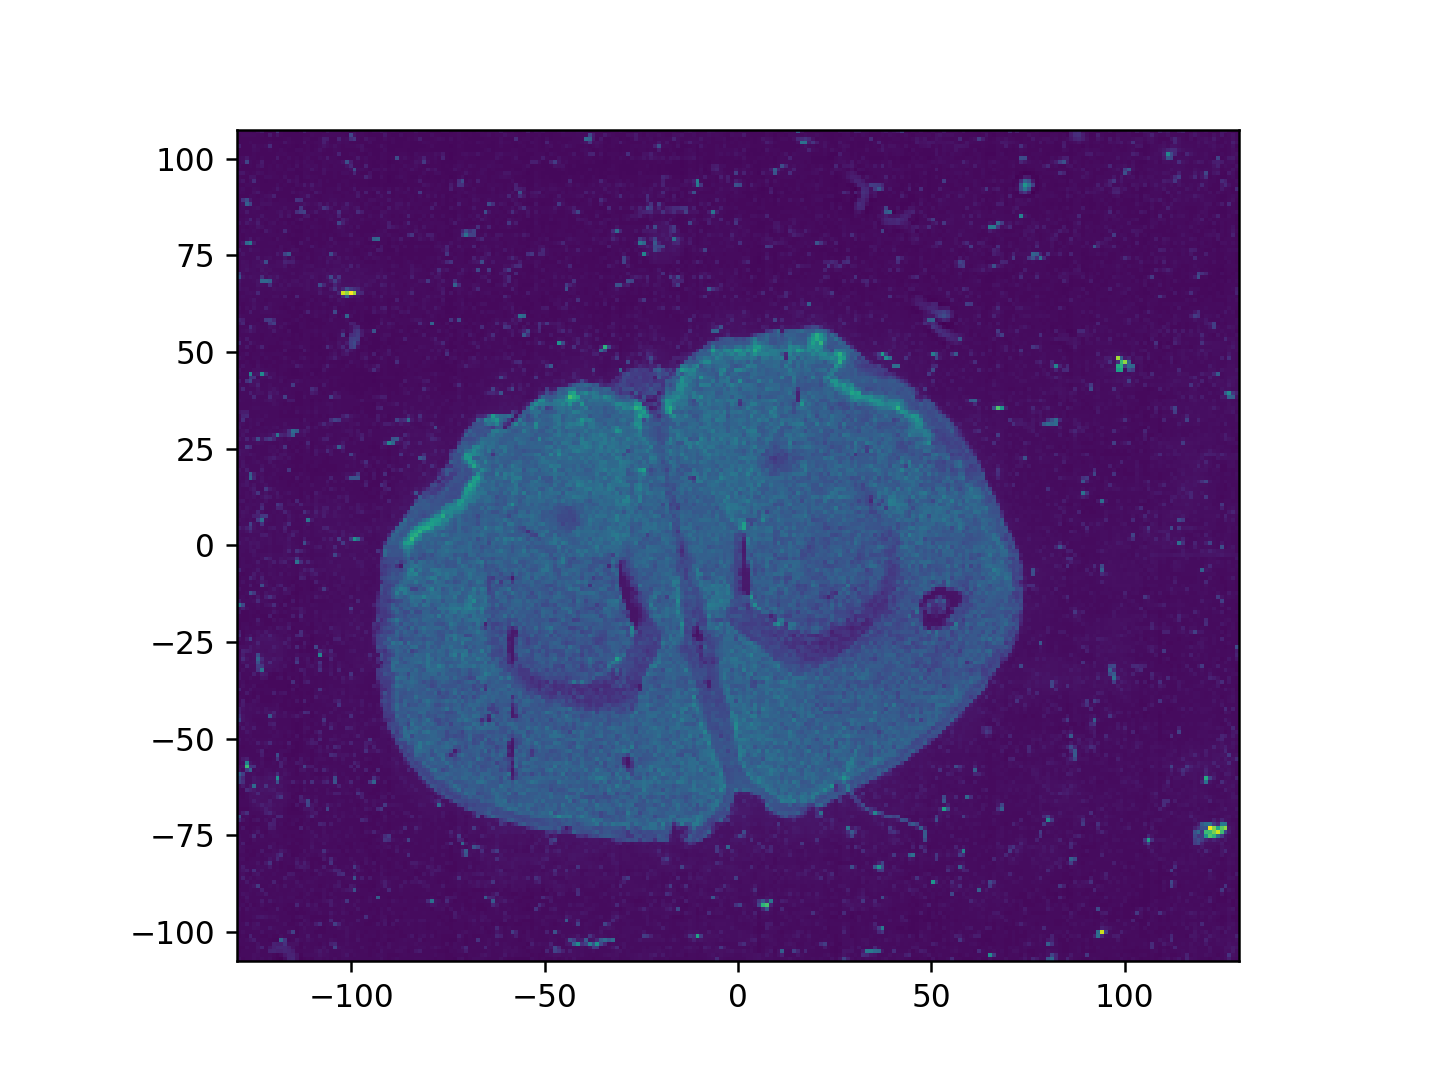

<IPython.core.display.Javascript object>


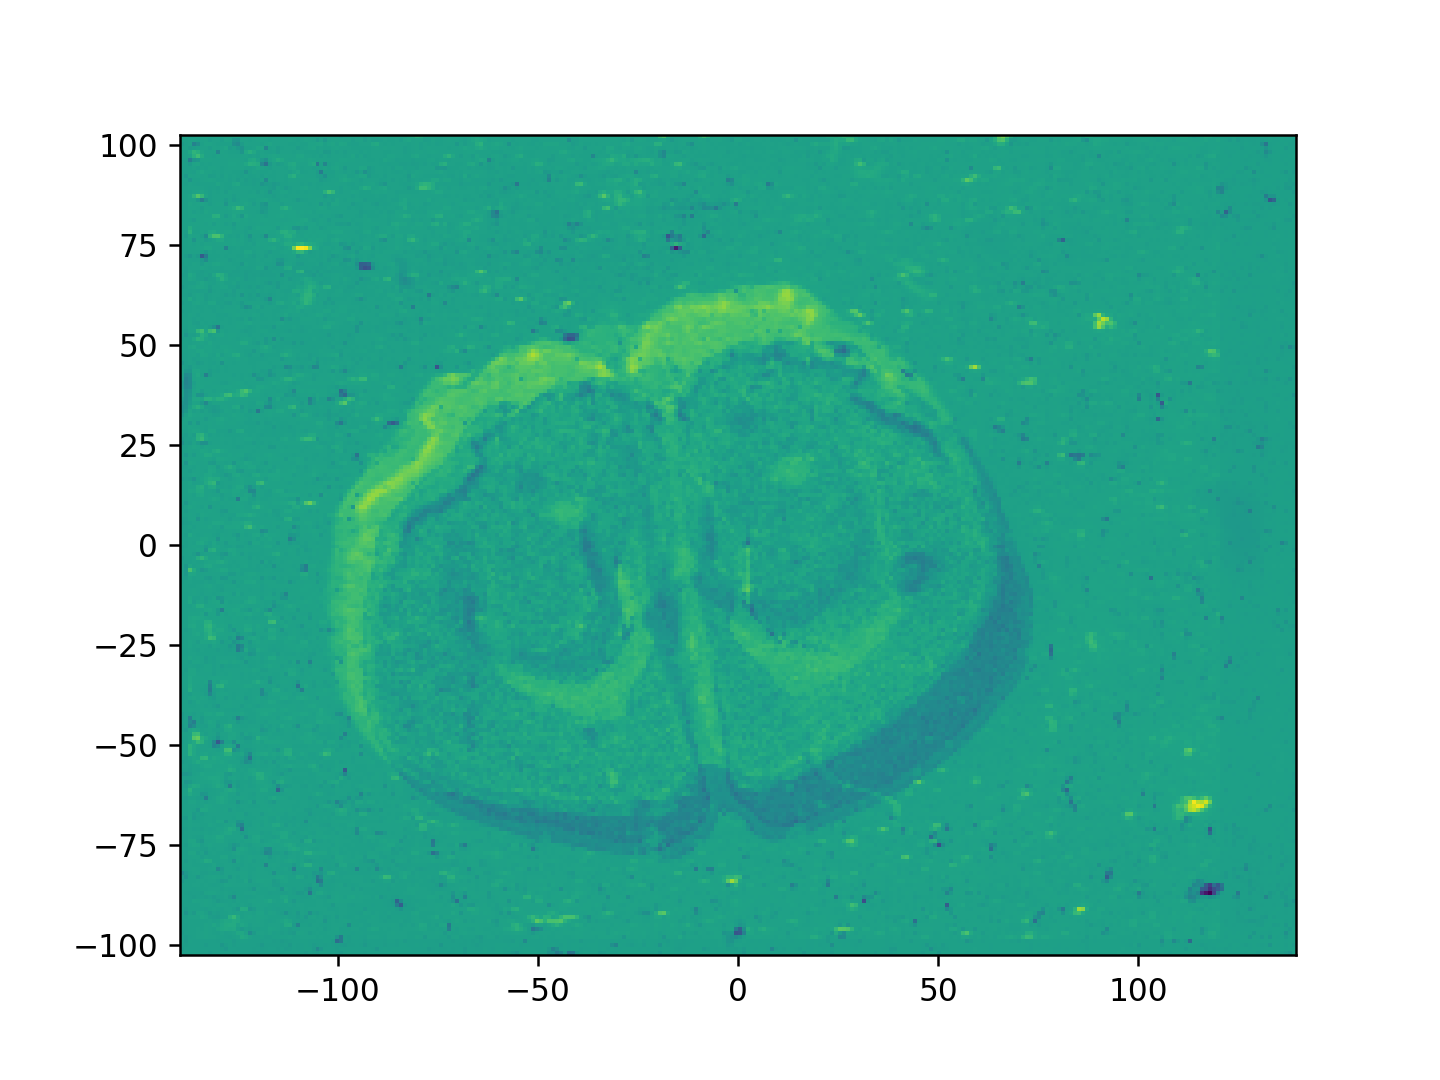

In [20]:
# Visualize the transformed images

dI = np.array([1,1])
dJ = np.array([1,1])
nI = np.array([ImageList[0].shape[0],ImageList[0].shape[1]])
nJ = np.array([ImageList[0+1].shape[0],ImageList[0+1].shape[1]])

def x_from_n_d(n,d,centered=True):
    return [np.arange(n_)*d_ - (n_-1)*d_/2.0*centered for n_,d_ in zip(n,d)]
x0 = x_from_n_d(nI,dI)
X0 = np.stack(np.meshgrid(*x0,indexing='ij'))
x1 = x_from_n_d(nJ,dJ)
X1 = np.stack(np.meshgrid(*x1,indexing='ij'))
xI = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nI,dI)] # sometimes I will put the origin in the middle
# check that origin is in the middle like this: np.mean(xI[0])
# the pixel size is important because we want the translation vector to have physical units in microns
xI[0],xI[1]=xI[1],xI[0]
xJ = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nJ,dJ)]
# now we'll build arrays that store pixel locations instead of lists
xJ[0],xJ[1]=xJ[1],xJ[0]


XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)


fig,ax = plt.subplots()
ax.imshow(ImageList[0],origin='lower',extent=(x0[1][0],x0[1][-1],x0[0][0],x0[0][-1]))
# make I1
thetastar = 0.015*np.pi/180
Rstar = np.array([[np.cos(thetastar),-np.sin(thetastar),8.96],[np.sin(thetastar),np.cos(thetastar),-8.46],[0,0,1]])
Ristar = np.linalg.inv(Rstar)

Xs = (Ristar[:2,:2]@X1.transpose(1,2,0)[...,None])[...,0] + Ristar[:2,-1]
RI0 = interpn(x0,ImageList[0],Xs,bounds_error=False,fill_value=0.0)
fig,ax = plt.subplots()
ax.imshow(RI0-ImageList[1],origin='lower',extent=(x1[1][0],x1[1][-1],x1[0][0],x1[0][-1]))

In [ ]:
# Plot figure for Time-Cost for MM and GD
fig,ax = plt.subplots()
plt.plot(GDCostList,GDTimeList,'r')
plt.plot(CostList,TimeList,'b')
plt.ylabel('Objective Func')
plt.xlabel('time')
plt.show()
ax.set_title('Time-Cost')

<IPython.core.display.Javascript object>


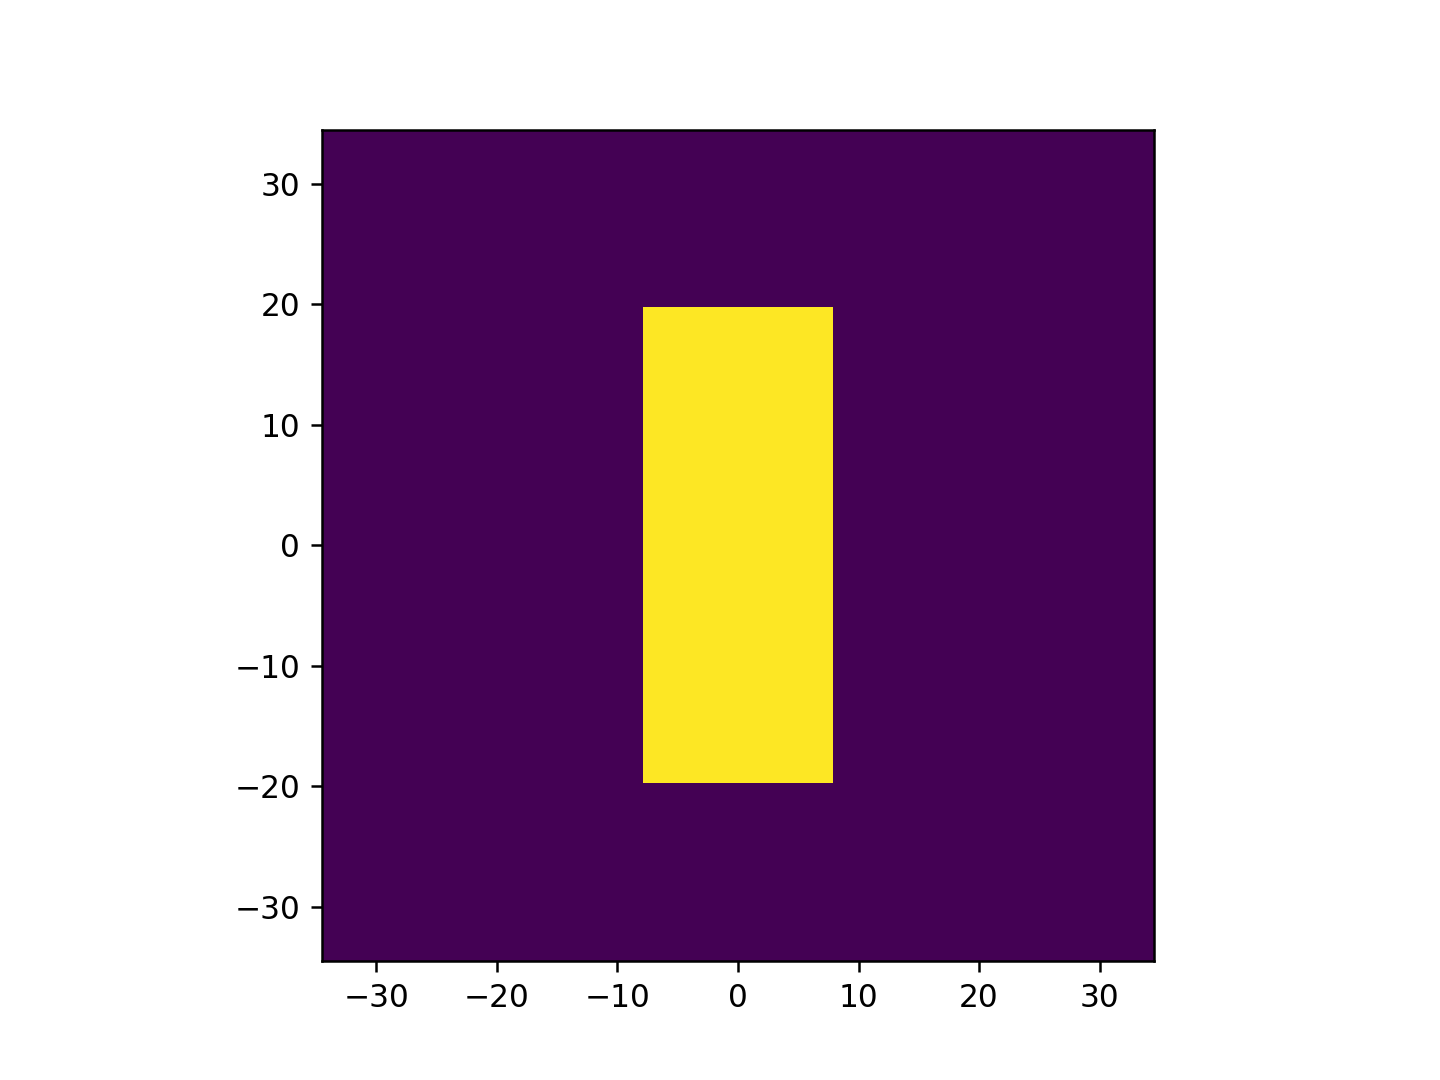

[[ 0.96592583  0.25881905 -3.15659652]
 [-0.25881905  0.96592583 -0.18946869]
 [ 0.          0.          1.        ]]


<IPython.core.display.Javascript object>


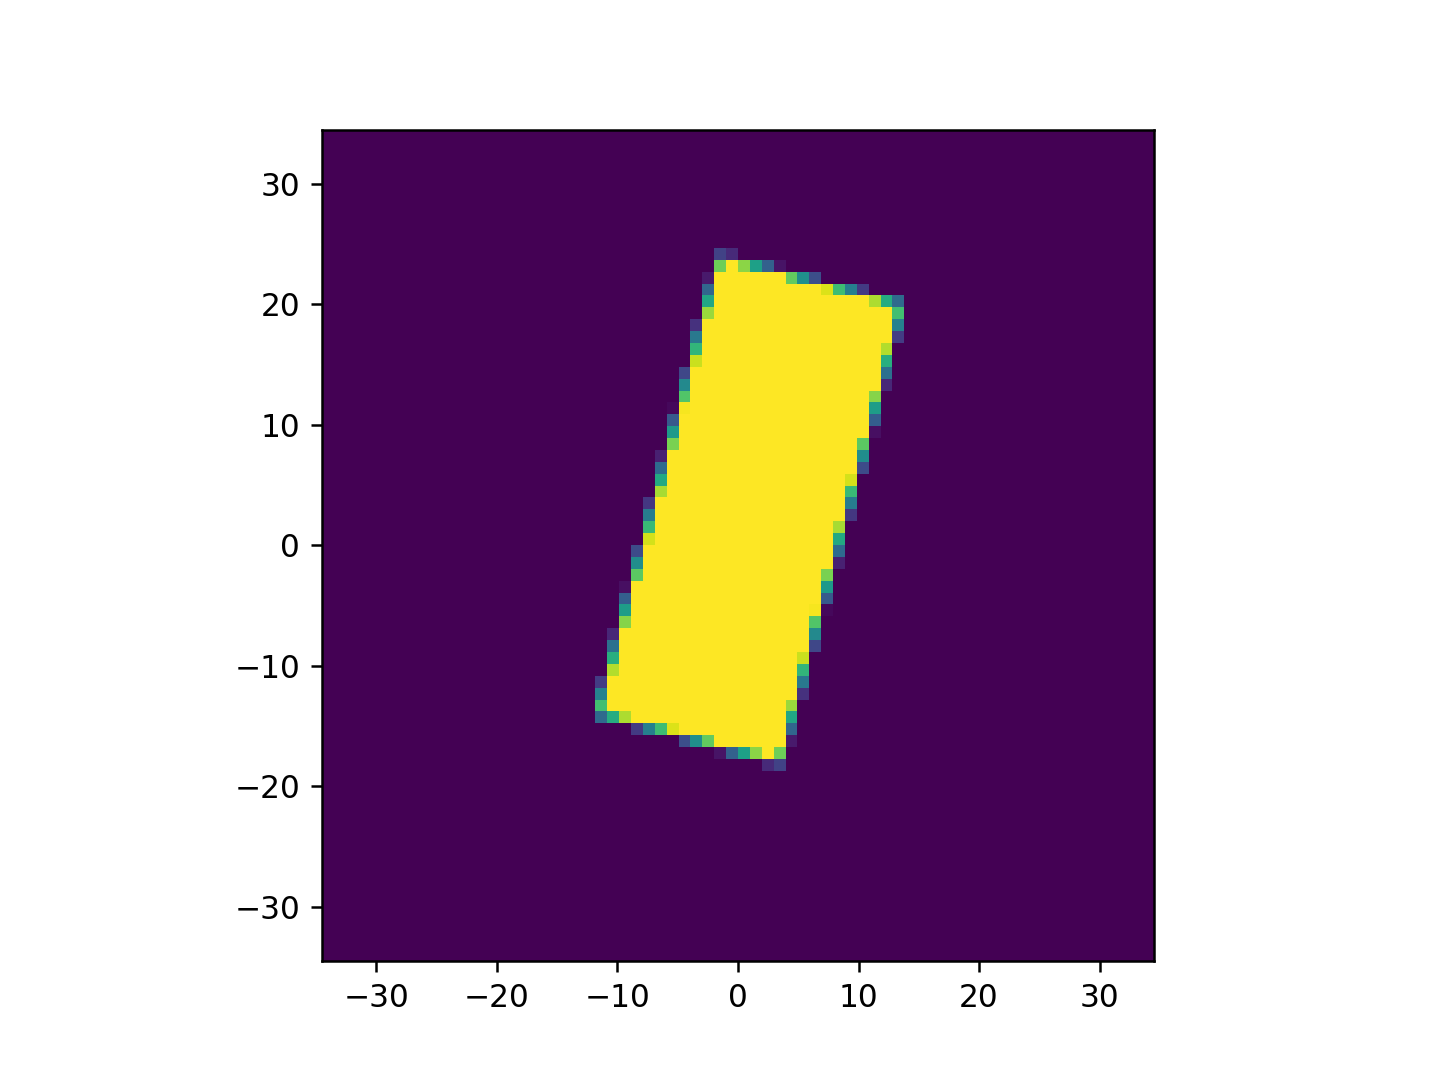

In [23]:
# Make simulated images

dI = np.array([1,1])
dJ = np.array([1,1])
nI = np.array([70,70])
nJ = np.array([70,70])

def x_from_n_d(n,d,centered=True):
    return [np.arange(n_)*d_ - (n_-1)*d_/2.0*centered for n_,d_ in zip(n,d)]
x0 = x_from_n_d(nI,dI)
X0 = np.stack(np.meshgrid(*x0,indexing='ij'))
x1 = x_from_n_d(nJ,dJ)
X1 = np.stack(np.meshgrid(*x1,indexing='ij'))
xI = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nI,dI)] # sometimes I will put the origin in the middle
# check that origin is in the middle like this: np.mean(xI[0])
# the pixel size is important because we want the translation vector to have physical units in microns
xI[0],xI[1]=xI[1],xI[0]
xJ = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nJ,dJ)]
# now we'll build arrays that store pixel locations instead of lists
xJ[0],xJ[1]=xJ[1],xJ[0]


XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
I0 = ((np.abs(X0[0]) <= 20.0)*(np.abs(X0[1]) < 8.0)).astype(float)

fig,ax = plt.subplots()
ax.imshow(I0,origin='lower',extent=(x0[1][0],x0[1][-1],x0[0][0],x0[0][-1]))
# make I1
thetastar = 15*np.pi/180
Rstar = np.array([[np.cos(thetastar),-np.sin(thetastar),3],[np.sin(thetastar),np.cos(thetastar),1],[0,0,1]])
Ristar = np.linalg.inv(Rstar)
print(Ristar)
Xs = (Ristar[:2,:2]@X1.transpose(1,2,0)[...,None])[...,0] + Ristar[:2,-1]
I1 = interpn(x0,I0,Xs,bounds_error=False,fill_value=0.0)
fig,ax = plt.subplots()
ax.imshow(I1,origin='lower',extent=(x1[1][0],x1[1][-1],x1[0][0],x1[0][-1]))